In [1]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

Q1a) What are probabilities and payout rates pregame?

In [2]:
lambda_= np.random.uniform(0.8,1.2, size=100000)
fh = np.random.poisson(lambda_)
sh = np.random.poisson(lambda_)
total=fh+sh

In [3]:
print("Goals\tprob\trate")
for i in range(0,7):
  p= (total==i).mean()
  print(f"{i}\t{p:.4f}\t{0.99/p:.2f}")

Goals	prob	rate
0	0.1374	7.20
1	0.2691	3.68
2	0.2671	3.71
3	0.1790	5.53
4	0.0913	10.85
5	0.0377	26.29
6	0.0134	73.83


Q1b) Observe fh=0

In [4]:
model = pm.Model()

with model:

    # Priors for unknown model parameters
    lambda_ = pm.Uniform("lambda_", lower=0.8, upper=1.2)
    sh = pm.Poisson("sh",mu=lambda_)

    # observations
    fh = pm.Poisson("fh",mu=lambda_, observed=0)

    #total
    total = pm.Deterministic('total',fh+sh)

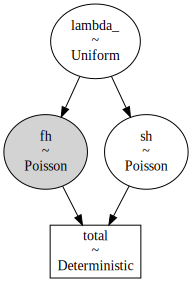

In [5]:
pm.model_to_graphviz(model)

In [5]:
with model:
    trace = pm.sample(draws= 20000,tune=1000,chains=4, random_seed=0)



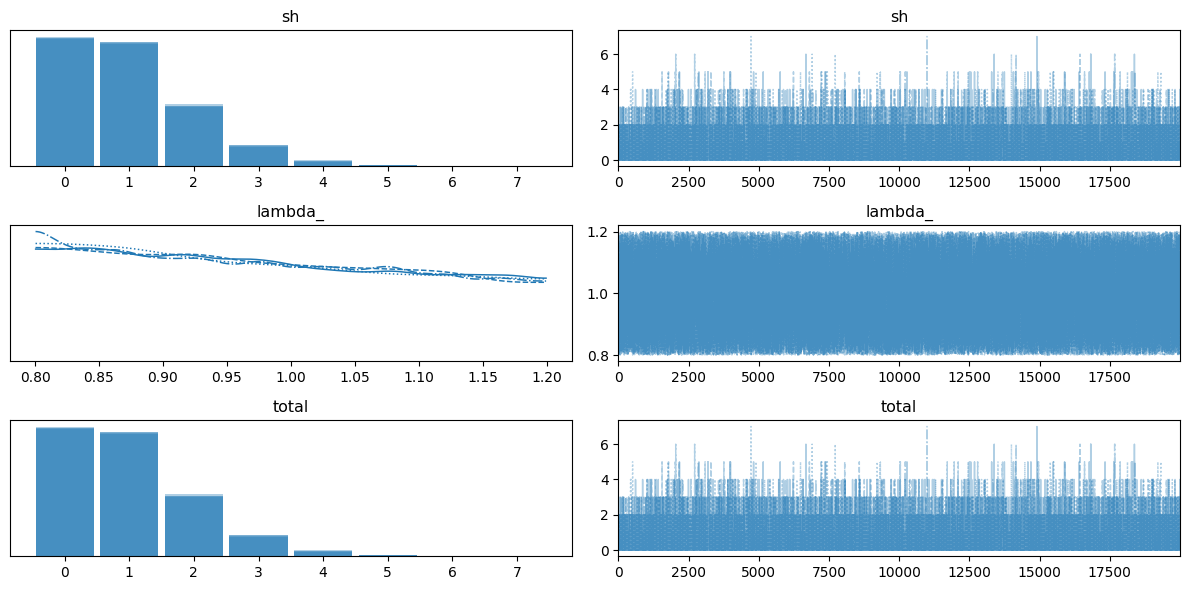

In [6]:
with model:
    az.plot_trace(trace)
    plt.tight_layout()

In [7]:
with model:
    display(az.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sh,0.983,1.002,0.0,3.000,0.011,0.008,9269.0,9863.0,1.0
lambda_,0.986,0.115,0.8,1.171,0.001,0.000,29449.0,40289.0,1.0
total,0.983,1.002,0.0,3.000,0.011,0.008,9269.0,9863.0,1.0


In [8]:
totalsamples = (trace['posterior']['total']).to_numpy()
print("Goals\tprob\trate")
for i in range(0,7):
  p= (totalsamples==i).mean()
  print(f"{i}\t{p:.4f}\t{0.99/p:.2f}")

Goals	prob	rate
0	0.3782	2.62
1	0.3640	2.72
2	0.1786	5.54
3	0.0599	16.53
4	0.0153	64.71
5	0.0034	290.11
6	0.0005	1885.71


Q3

In [9]:
def Ufunc(x):
  return np.where(x<0, 0.42 + (0.42/30)*x,
                  np.where(x<35, 0.42 + ((0.75-0.42)/35)*x,
                           0.5 + (1-0.75)/(70-35)*x
                           ))

In [10]:
#Policy 1. No Market Research, Invest
Q= np.random.uniform(0,10, size=1000000)
X = 10*(7-Q)
U = Ufunc(X)
U.mean()

0.5743718459492376

In [11]:
#Policy 3. Market Research. Follow advice
Q= np.random.uniform(0,10, size=1000000)
R = np.random.binomial(n=1, p= (10-Q)/10) #bernoulli is binomial with n=1

X = np.where(R>0.5,
             10*(7-Q) -1,
             -1)
U = Ufunc(X)
U.mean()

0.567061198174202

Q3b) What is E[U | R=1]

In [8]:
def UfuncPyMC(x):
  return pm.math.where(x<0, 0.42 + (0.42/30)*x,
                  pm.math.where(x<35, 0.42 + ((0.75-0.42)/35)*x,
                           0.5 + (1-0.75)/(70-35)*x
                           ))

In [9]:
model = pm.Model()

with model:

    # Priors for unknown model parameters
    Q = pm.Uniform("Q", lower=0, upper=10)
    # observations
    R = pm.Bernoulli("R",p=(10-Q)/10, observed=1)

    X= pm.Deterministic("X",10*(7-Q) -1)
    U = pm.Deterministic("U", UfuncPyMC(X))

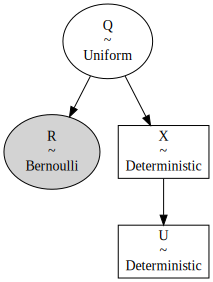

In [11]:
pm.model_to_graphviz(model)

In [14]:
with model:
    trace = pm.sample(draws= 20000,tune=1000,chains=4, random_seed=0, return_inferencedata=False)

In [15]:
(trace['U']).mean()

0.7283992907852934